In [1]:
import desdeo

In [2]:
import numpy as np

from desdeo.problem import (PolarsEvaluator, Problem, VariableType,
                            variable_dict_to_numpy_array, Constraint,
                            ConstraintTypeEnum, Variable, VariableTypeEnum, ScalarizationFunction
                            )
from desdeo.tools.utils import (
    get_corrected_ideal_and_nadir,
    get_corrected_reference_point,
)
from desdeo.tools.scalarization import objective_dict_has_all_symbols

from desdeo.problem.testproblems import dtlz2, nimbus_test_problem

# from desdeo.mcdm.gnimbus import infer_classifications, solve_intermediate_solutions, solve_sub_problems
from gnimbus import (explain, voting_procedure, infer_classifications, agg_cardinal, infer_ordinal_classifications,
                     solve_intermediate_solutions, solve_sub_problems, convert_to_nimbus_classification, add_group_nimbusv2_sf_diff,
                     list_of_rps_to_dict_of_rps, dict_of_rps_to_list_of_rps)

from desdeo.problem import dtlz2, nimbus_test_problem, zdt1, zdt2
from desdeo.tools import IpoptOptions, PyomoIpoptSolver, add_asf_diff

from aggregate_classifications import aggregate_classifications


from desdeo.tools import (
    BaseSolver,
    SolverOptions,
    SolverResults,
    add_group_asf_diff,
    add_group_asf,
    add_group_guess_sf_diff,
    add_group_guess_sf,
    add_group_nimbus_sf_diff,
    add_group_nimbus_sf,
    add_group_stom_sf_diff,
    add_group_stom_sf,
    guess_best_solver,
    add_asf_diff,
    ScalarizationError,
    add_nimbus_sf_diff, add_nimbus_sf_nondiff
)
from desdeo.mcdm.nimbus import (
    generate_starting_point,
    infer_classifications,
    NimbusError
)

from aggregate_classifications import aggregate_classifications

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
"""Test that the scalarization problems in GNIMBUS are solved as expected."""
n_variables = 8
n_objectives = 3

problem = dtlz2(n_variables, n_objectives)

solver_options = IpoptOptions()

# get some initial solution
initial_rp = {
    "f_1": 0.4, "f_2": 0.5, "f_3": 0.8
}
initial_result = generate_starting_point(problem, initial_rp)

# f1: 0.385, f2: 0.485, f3: 0.776
initial_fs = initial_result.optimal_objectives
initial_fs


{'f_1': 0.38509817535988233,
 'f_2': 0.48509817753491596,
 'f_3': 0.7850981807944739}

## Learning phase

### 1. DMs give prefs ( example where DMs preferences conflict heavily.)

In [16]:
# for first iteration
next_current_solution = initial_result.optimal_objectives
print(f"initial solution: {next_current_solution}")

initial solution: {'f_1': 0.38509817535988233, 'f_2': 0.48509817753491596, 'f_3': 0.7850981807944739}


In [19]:
dms_rps = {
    "DM1": {"f_1": 0.0, "f_2": next_current_solution["f_2"], "f_3": 1},  # improve f_1, keep f_2 same, impair f_3
    "DM2": {"f_1": 0.3, "f_2": 1, "f_3": 0.5},  # improve f_1 to 0.3, impair f_2, improve f_3 to 0.5
    "DM3": {"f_1": 0.5, "f_2": 0.6, "f_3": 0.0},  # impair f_1 to 0.5, impair f_2 to 0.6, improve f_3
}

### 2. Run first iteration

In [20]:
num_desired = 4
solutions = solve_sub_problems(
    problem, next_current_solution, dms_rps, num_desired, False, create_solver=PyomoIpoptSolver, solver_options=solver_options
)
for s in solutions:
    print(f"Solution: {s.optimal_objectives}")

gnimbus = solutions[0].optimal_objectives
gstom = solutions[1].optimal_objectives
gasf = solutions[2].optimal_objectives
gguess = solutions[3].optimal_objectives

RPS {'f_1': 0.0, 'f_2': 0.8535307961578433, 'f_3': 1}
RPS {'f_1': 0.3, 'f_2': 1, 'f_3': 0.5}
RPS {'f_1': 0.5, 'f_2': 0.6, 'f_3': 0.0}
Solution: {'f_1': 0.3684326025012598, 'f_2': 0.8535308048014998, 'f_3': 0.3684326026141725}
Solution: {'f_1': -1.3214398403123894e-08, 'f_2': 0.9999999999999998, 'f_3': -1.3234075331643097e-08}
Solution: {'f_1': 0.30332229109326425, 'f_2': 0.9033222989233354, 'f_3': 0.3033222906312579}
Solution: {'f_1': 0.9999999999999998, 'f_2': -1.3202083146926173e-08, 'f_3': -1.3202067291775593e-08}


### Plot the solutions

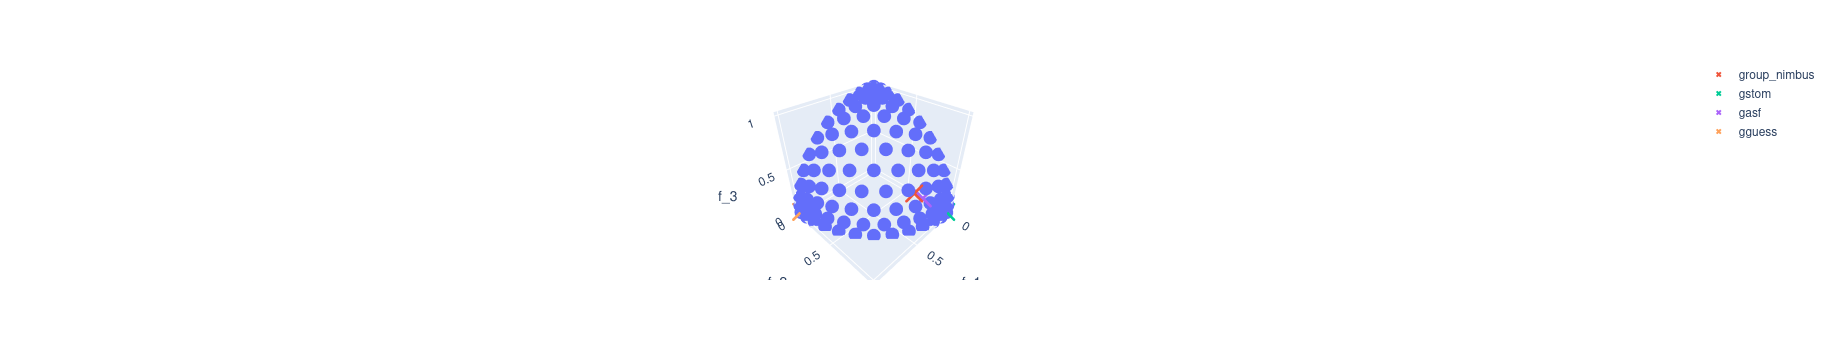

In [68]:
from pymoo.problems import get_problem
import plotly.express as px
import plotly.graph_objects as go

import pandas as pd
from pymoo.util.plotting import plot
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

pf = get_problem("dtlz2").pareto_front(ref_dirs)
#PF = [dict(zip(keys, row)) for row in pf]

solutions = [gnimbus, gstom, gasf, gguess]

keys = ["f_1", "f_2", "f_3"]
namelist = ["group_nimbus", "gstom", "gasf", "gguess"]

visu_3d(pf, solutions, keys, namelist)

In [67]:
def visu_3d(pymoo_problem_pf, solutions, keys, names):
    all_solutions = {
        "f_1": [s[keys[0]] for s in solutions],
        "f_2": [s[keys[1]] for s in solutions],
        "f_3": [s[keys[2]] for s in solutions],
        "names": namelist,
    }
    all_solutions = pd.DataFrame(all_solutions, columns=[keys[0],keys[1],keys[2], "names"])
    PF = [dict(zip(keys, row)) for row in pymoo_problem_pf]
    fig = px.scatter_3d(PF, x=keys[0], y=keys[1],z=keys[2])
    # TODO: figure out the marker styles better
    #fig.add_scatter(x=[cip[0]], y=[cip[1]], mode="markers", name="CIP", showlegend=True, marker=dict(size=15, symbol="star"))
    #fig.add_scatter(x=[ideal[0]], y=[ideal[1]], mode="markers", name="ideal", showlegend=True, marker=dict(size=15, symbol="star"))
    # fig.update_traces(marker=dict(size=15, symbol="star"))
    # plot RPs
    #for i in range(len(rp_arr)):
    #    fig.add_scatter(x=[rp_arr[i][0]], y=[rp_arr[i][1]], mode="markers", name=f"DM{i+1}_RP", showlegend=True, marker=dict(size=15, symbol="x"))

    # PLOT GRP
    #fig.add_scatter(x=[meanGRP_arr[0]], y=[meanGRP_arr[1]], mode="markers", name="GRP_mean", showlegend=True, marker=dict(size=15, symbol="diamond"))
    #fig.add_scatter(x=[grpmm_ext[0]], y=[grpmm_ext[1]], mode="markers", name="GRP_mm_ext", showlegend=True, marker=dict(size=15, symbol="cross"))
    #fig.add_scatter(x=[grpmm[0]], y=[grpmm[1]], mode="markers", name="GRP_mm", showlegend=True, marker=dict(size=15, symbol="diamond-tall"))
    #fig.add_scatter(x=[grpcones[0]], y=[grpcones[1]], mode="markers", name="GRP-cones", showlegend=True, marker=dict(size=15, symbol="diamond-wide"))
    # fig.update_traces(marker=dict(size=15, symbol="x"))
    # fig.update_traces(marker=dict(size=15, symbol="star"))
    # fig.update_traces(marker=dict(size=15))
    # PLOT results
    # fig.add_scatter(all_solutions,  x=all_solutions.f_1, y=all_solutions.f_2, mode="markers", name=all_solutions.names ,showlegend=True)
    for i in range(len(namelist)):
        fig.add_trace(go.Scatter3d(x=[all_solutions["f_1"][i]], y=[all_solutions["f_2"][i]], z=[all_solutions["f_3"][i]],mode="markers",
                        name=all_solutions.names[i], showlegend=True, marker=dict(size=5, symbol="x")))

    # fig.add_scatter(all_solutions, x="f_1", y="f_2", mode="markers", name="ASF",showlegend=True)
    # fig.add_scatter(all_solutions, x="f_1", y="f_2", mode="markers", name="ASF",showlegend=True)
    # fig.add_traces(all_solutions)
    # fig.update_traces(marker=dict(size=15))
    # fig.update_traces(marker=dict(size=15, symbol="x"))


    fig.show()

### 3. select the next current iteration point by voting procedure

In [21]:
votes_idxs = {
        "DM1": 1,
        "DM2": 2,
        "DM3": 2,
}
res = voting_procedure(problem, solutions, votes_idxs)
next_current_solution = res.optimal_objectives
print("next current solution:", next_current_solution)

Majority winner 2
next current solution: {'f_1': 0.30332229109326425, 'f_2': 0.9033222989233354, 'f_3': 0.3033222906312579}


In [12]:
# select the next current iteration point
#current_it = gnimbus
#print(f"current solution: {current_it}")

current solution: {'f_1': 0.3850981799798765, 'f_2': 0.6000000070543984, 'f_3': 0.701212794600119}


In [12]:
# for other iterations
dms_rps = {
    "DM1": {"f_1": 0.3, "f_2": 0.6, "f_3": 1},
    "DM2": {"f_1": 0.3, "f_2": 0.9, "f_3": 0.5},
    "DM3": {"f_1": 0.4, "f_2": 0.7, "f_3": 0.4},
}

### Go back to step 4 or move to decision phase

# "Decision phase"

In [26]:
# for other iterations
dms_rps = {
    "DM1": {"f_1": 0.3, "f_2": 0.6, "f_3": 1},
    "DM2": {"f_1": 0.3, "f_2": 0.2, "f_3": 0.5},
    "DM3": {"f_1": 0.4, "f_2": 0.1, "f_3": 0.4},
}

### let us only propose one solution found by group nimbus which respects each DMs bounds.

In [27]:
num_desired = 1 
solutions = solve_sub_problems(
    problem, next_current_solution, dms_rps, num_desired, False, create_solver=PyomoIpoptSolver, solver_options=solver_options
)
gnimbus_solution = solutions[0].optimal_objectives
print("Final solution candidate:", gnimbus_solution)

RPS {'f_1': 0.3, 'f_2': 0.6, 'f_3': 1}
RPS {'f_1': 0.3, 'f_2': 0.2, 'f_3': 0.5}
RPS {'f_1': 0.4, 'f_2': 0.1, 'f_3': 0.4}
Final solution candidate: {'f_1': 0.3033222916409733, 'f_2': 0.8648673756862045, 'f_3': 0.400000012334157}


# Ask if the DMs agree upon the final solution. Otherwise go to group discussion.

# Group discussion:
- give DMs information about the state; what is achievable and what is not, unless preferences are changed. explain why not moving etc.
- Nudge or ask DMs to adjust their preferences to find better suiting solutions for the group.
- Finally, set next_current_solution to gnimbus_solution and go back to DMs giving preferences for the next iteration

In [25]:
next_current_solution = gnimbus_solution

In [33]:
from desdeo.problem.testproblems import forest_problem_discrete
import polars as pl
# TODO: update this
forest_problem = forest_problem_discrete()  # or use forest_problem()
total_steps = 5
for i in range(3):
    print(forest_problem.objectives[i].ideal)
    print(forest_problem.objectives[i].nadir)

initial_rp = {
    "stock": 1000,
    "harvest_value": 1000,
    "npv": 80000,
}
# get some initial solution
initial_result = generate_starting_point(forest_problem, initial_rp)

next_current_solution = initial_result.optimal_objectives
# ITERATION LOOP FOR LEARNING PHASE
reference_points = {
    "DM1": {
        "stock": 1000,
            "harvest_value": 1000,
            "npv": 80000,
        },
        "DM2": {
            "stock": 3000,
            "harvest_value": 22200.5,
            "npv": 72000,
        },
        "DM3": {
            "stock": 2000,
            "harvest_value": 50005,
            "npv": 80000,
        },
        "DM4": {
            "stock": 1500,
            "harvest_value": 100,
            "npv": 90000,
        },
        "DM5": {
            "stock": 3200,
            "harvest_value": 900,
            "npv": 75000,
        },
}
# TODO: learning phase
num_desired = 5  # TODO: add more scalarization to get atleast 5 solutions.
solutions = solve_sub_problems(
    problem, next_current_solution, reference_points, num_desired, decision_phase=False,
)
for i in solutions:
    print(solutions[i].optimal_objectives)
votes_idx = {
    "DM1": 1,
    "DM1": 0,
    "DM1": 3,
    "DM1": 2,
    "DM1": 3,
}
voted_sol = voting_procedure(votes_idx)
next_current_solution = voted_sol
print(next_current_solution)
# ITERATION LOOP FOR DECISION PHASE
reference_points = {
"DM1": {
    "stock": 1000,
    "harvest_value": 1000,
    "npv": 80000,
},
"DM2": {
    "stock": 3000,
    "harvest_value": 22200.5,
    "npv": 72000,
},
"DM3": {
    "stock": 2000,
    "harvest_value": 50005,
    "npv": 80000,
},
"DM4": {
    "stock": 1500,
        "harvest_value": 100,
        "npv": 90000,
    },
"DM5": { 
        "stock": 3200,
        "harvest_value": 900,
        "npv": 75000,
    },
}
# TODO: learning phase
num_desired = 1
solutions = solve_sub_problems(
    problem, next_current_solution, reference_points, num_desired, decision_phase=True,
)
for i in solutions:
    print(solutions[i].optimal_objectives)
votes_idx = {
    "DM1": 1,
    "DM1": 0,
    "DM1": 3,
    "DM1": 2,
    "DM1": 3,
}
voted_sol = voting_procedure(votes_idx)
next_current_solution = voted_sol
print(next_current_solution)

3422.75801
834.9086809
74114.92657
0.0
91494.0437
70547.89613


ColumnNotFoundError: _alpha

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'select' <---
DF ["index", "stock", "harvest_value", "npv"]; PROJECT */7 COLUMNS; SELECTION: None